In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import tqdm
import json
import torch
import hydra
import pprint
import logging
import colorlog
import src.prepare  # noqa
import logging.config

import numpy as np
import pytorch_lightning as pl

from src.config import read_config
from hydra.utils import instantiate
from src.load import load_model_from_cfg
from omegaconf import OmegaConf, DictConfig
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

/home/nadir/tmr-code/.tmr.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
LOGGING_CONFIG = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'simple': {
            'format': '[%(asctime)s][%(name)s][%(levelname)s] - %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
        },
        'colorlog': {
            '()': 'colorlog.ColoredFormatter',
            'format': '[%(white)s%(asctime)s%(reset)s] %(log_color)s%(levelname)s%(reset)s   %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
            'log_colors': {
                'DEBUG': 'purple',
                'INFO': 'blue',
                'WARNING': 'yellow',
                'ERROR': 'red',
                'CRITICAL': 'red',
            },
        },
    },
}

logging.config.dictConfig(LOGGING_CONFIG)

logger = logging.getLogger(__name__)

logger.info("logger has been configured.")

<div class="alert alert-info">

**source:** [hydra configurations in a notebook](https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb).

</div>

In [ ]:
RUN_DIRS = [
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_20",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_25",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_30",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_35",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_40",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_45",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_50",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_20",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_25",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_30",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_35",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_40",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_45",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_50",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_20",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_25",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_30",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_35",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_40",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_45",
    "/home/nadir/disk/tmr-training-model-archive/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_50"
]
output_paths = RUN_DIRS

In [6]:
def load_segmentation_metrics(output_path):
    """Load segmentation evaluation metrics from JSON file"""
    metrics_path = os.path.join(output_path, "segmentation-evaluation", "metrics.json")
    
    try:
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                return json.load(f)
    except Exception as e:
        print(f"Error loading metrics from {output_path}: {e}")
    return None

def parse_model_info(output_path):
    """Parse model information from output path"""
    parts = os.path.basename(output_path).split('_')
    encoder_type = parts[1]  # stgcn or tmr
    pretrained = parts[2] == 'True'
    window_size = int(parts[4])
    
    if encoder_type == 'stgcn':
        model_name = "ST-GCN"
    elif encoder_type == 'tmr' and not pretrained:
        model_name = "TMR (no pretraining)"
    else:  # tmr with pretraining
        model_name = "TMR (with pretraining)"
    
    return model_name, window_size

In [7]:
def get_config(index: int):
    with initialize(
        version_base=None,
        config_path="configs",
        # 
    ):
        # config = compose(overrides=["+db=mysql"])
        config = compose(
            config_name="evaluate-start-end-segmentation-segmenter",
            return_hydra_config=True,
            overrides=[f"run_dir={RUN_DIRS[index]}"]
        )
        
        from hydra.core.hydra_config import HydraConfig
        
        HydraConfig.instance().set_config(config)
        
        return config

In [8]:
def prepare(config, with_seeding=True, pretrained=True):
    device = config.device
    run_dir = config.run_dir
    examples = config.examples
    ckpt_name = config.ckpt

    save_dir = os.path.join(run_dir, "segmentation-evaluation")
    os.makedirs(save_dir, exist_ok=True)
    
    print("[config.data]:", config.data)
    
    window_size = int(run_dir.split("_mlp_")[1])

    # NOTE: moved up here in order to use the segmentation config for the dataset
    # defined in the config file rather than the config used to train the model
    dataset = instantiate(
        config.data,
        dir="/home/nadir/disk/datasets/babel-for-validation",
        window_size=window_size,
        split="all",
        for_validation=True,
        normalize=False,
    )
    
    normalization_statistics = torch.load(os.path.join(dataset.dir, "motion_normalization_stats.pt"))

    mean = normalization_statistics["mean"]
    std = normalization_statistics["std"]
    
    print("[mean.shape]:", mean.shape)
    print("[std.shape]:", std.shape)

    # NOTE: will load the config used to train the model
    
    cfg = read_config(run_dir)

    pl.seed_everything(cfg.seed)

    logger.info("[model]: loading")
    model = load_model_from_cfg(cfg, ckpt_name, eval_mode=True, device=device, pretrained=pretrained)

    model = model.eval()
    
    return model, dataset, device, window_size, mean, std

In [9]:
# config = get_config(8)
# NOTE: best performing model F1@1.00: 0.3985
config = get_config(2)

metrics = load_segmentation_metrics(config.run_dir)

print("[config.run_dir]:", config.run_dir)
print("[metrics]:", metrics)

model, dataset, device, window_size, mean, std = prepare(config, pretrained=True)

print("[#dataset]:", len(dataset))

Global seed set to 1234


[config.run_dir]: /home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_30
[metrics]: {'framewise_accuracy': 0.7542819841791779, 'edit_score': 0.7581631750149461, 'f1_scores': {'f1@0.10': 0.6498481359512902, 'f1@0.20': 0.609294584768928, 'f1@0.30': 0.5667544501220472, 'f1@0.40': 0.5314178667509803, 'f1@0.50': 0.4935901792035564, 'f1@0.60': 0.4557395619248118, 'f1@0.70': 0.4180128056065139, 'f1@0.80': 0.3794655299663074, 'f1@0.90': 0.34025256807251864, 'f1@1.00': 0.298188085988086}, 'false_positive_score': 0.205398659393305, 'transition_count_accuracy': 0.39310475559069935, 'balanced_accuracy': 0.6422304692539461, 'matthews_corrcoef': 0.19559954638015495, 'per_class': {'0.0': {'precision': 0.9342358894722349, 'recall': 0.7717013144401976, 'f1': 0.8452257940673155}, '1.0': {'precision': 0.20026125008164064, 'recall': 0.5127596240676946, 'f1': 0.28803051083096926}}}
[config.data]: {'_target_': 'src.data.windowed_dataset.WindowedDataset', 'dir': 

[index]: 192
[outputs.shape]: torch.Size([175])
[labels.shape]: (175,)
[preds.shape]: (175,)


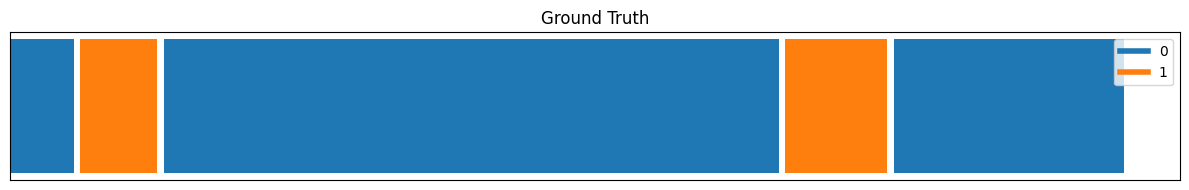

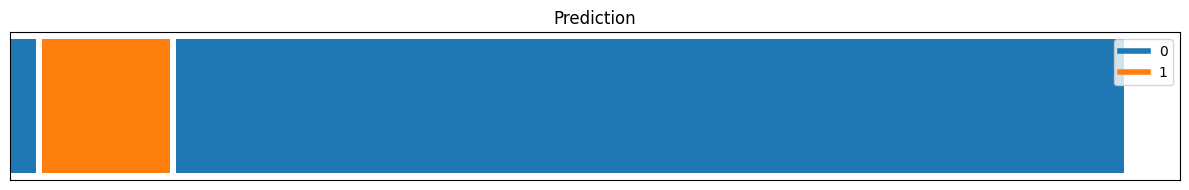

--- --- --- --- --- --- ---
[index]: 787
[outputs.shape]: torch.Size([63])
[labels.shape]: (63,)
[preds.shape]: (63,)


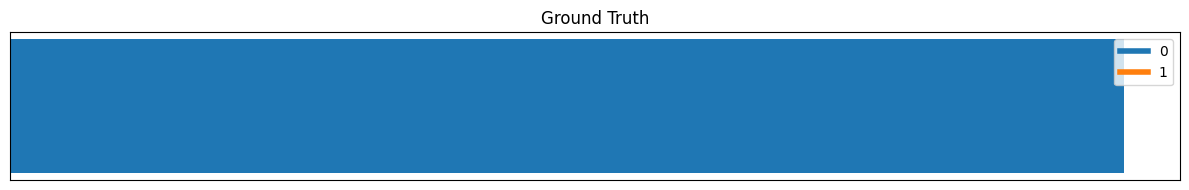

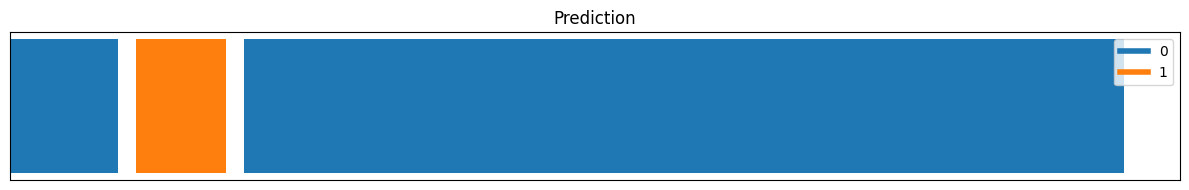

--- --- --- --- --- --- ---
[index]: 564
[outputs.shape]: torch.Size([110])
[labels.shape]: (110,)
[preds.shape]: (110,)


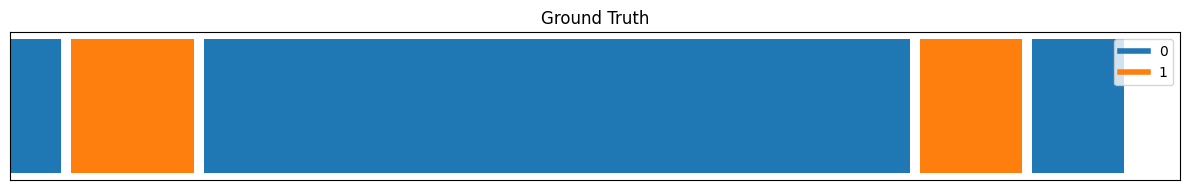

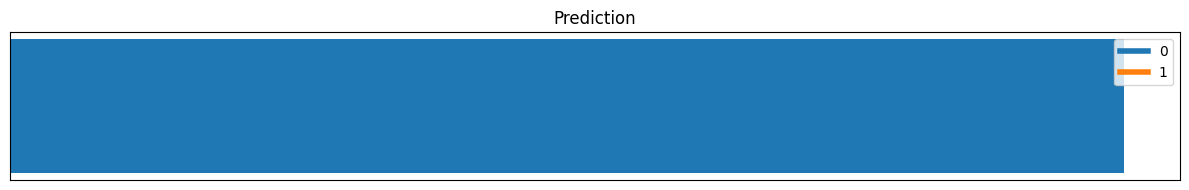

--- --- --- --- --- --- ---
[index]: 541
[outputs.shape]: torch.Size([159])
[labels.shape]: (159,)
[preds.shape]: (159,)


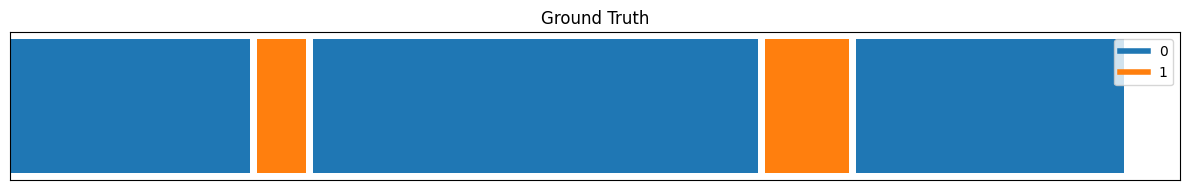

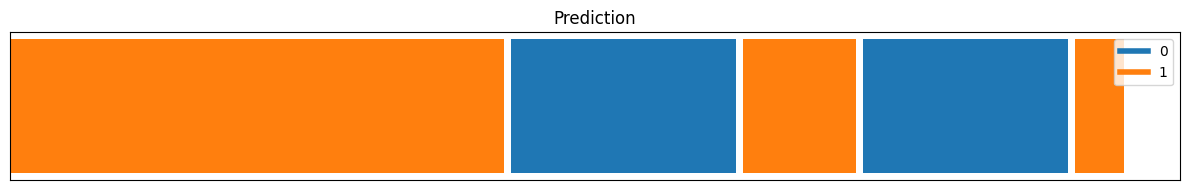

--- --- --- --- --- --- ---
[index]: 522
[outputs.shape]: torch.Size([85])
[labels.shape]: (85,)
[preds.shape]: (85,)


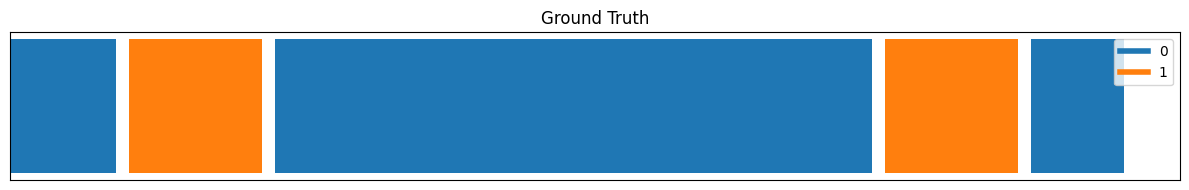

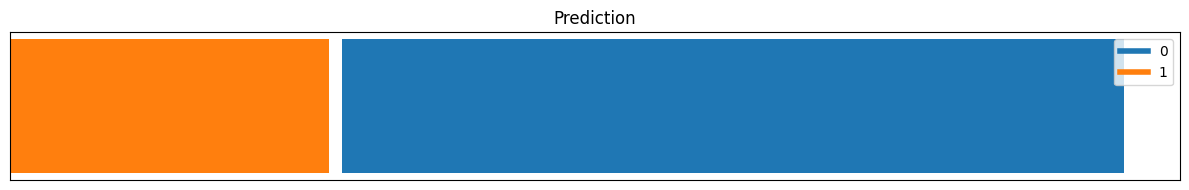

--- --- --- --- --- --- ---
[index]: 1415
[outputs.shape]: torch.Size([46])
[labels.shape]: (46,)
[preds.shape]: (46,)


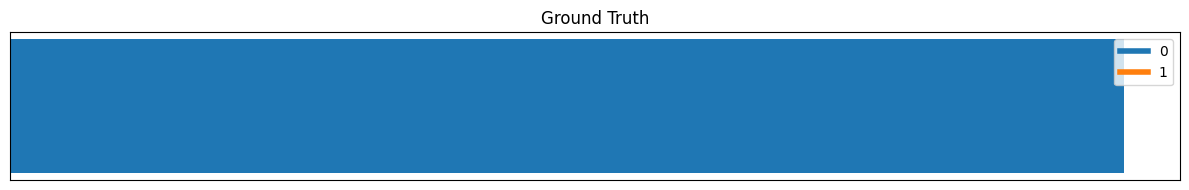

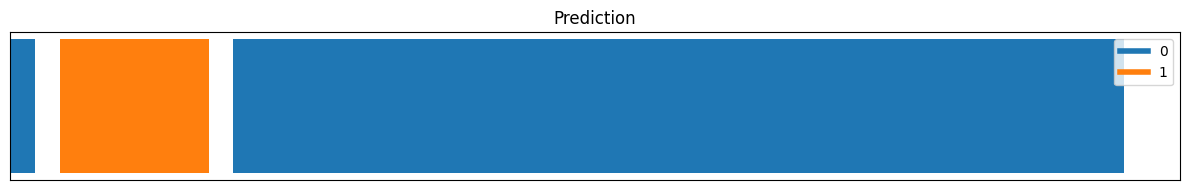

--- --- --- --- --- --- ---
[index]: 648
[outputs.shape]: torch.Size([505])
[labels.shape]: (505,)
[preds.shape]: (505,)


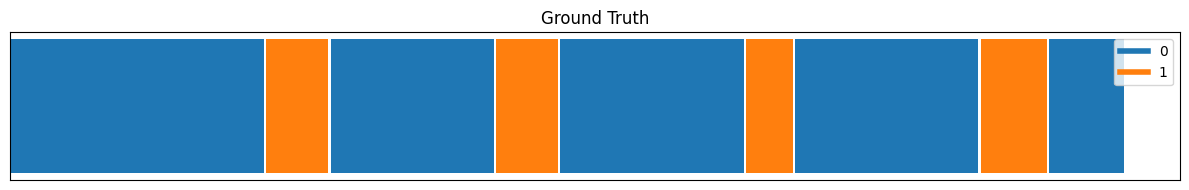

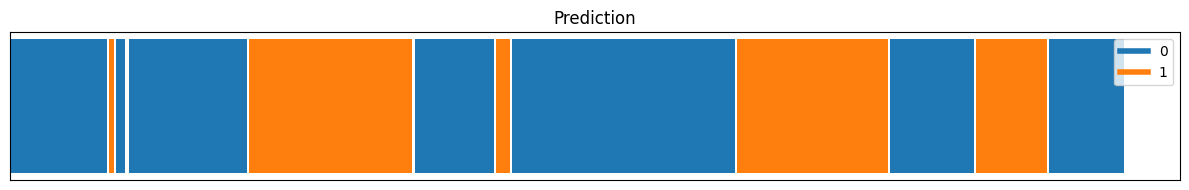

--- --- --- --- --- --- ---
[index]: 619
[outputs.shape]: torch.Size([200])
[labels.shape]: (200,)
[preds.shape]: (200,)


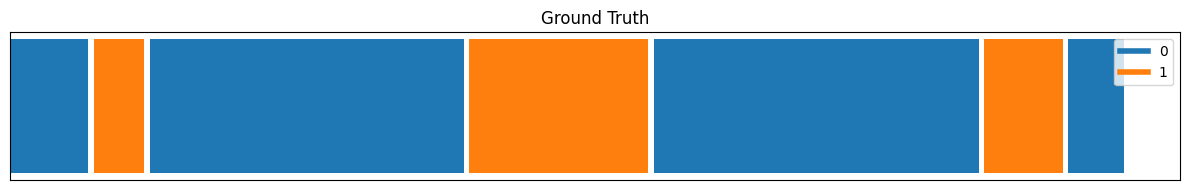

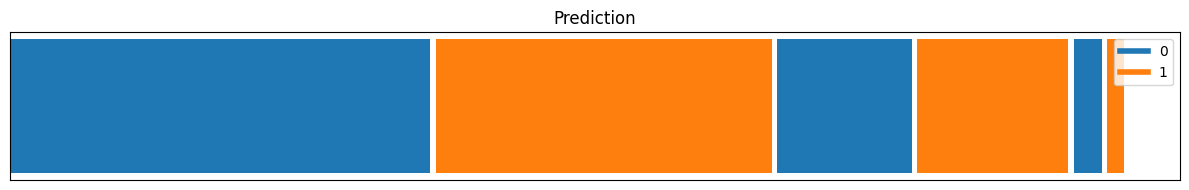

--- --- --- --- --- --- ---
[index]: 700
[outputs.shape]: torch.Size([493])
[labels.shape]: (493,)
[preds.shape]: (493,)


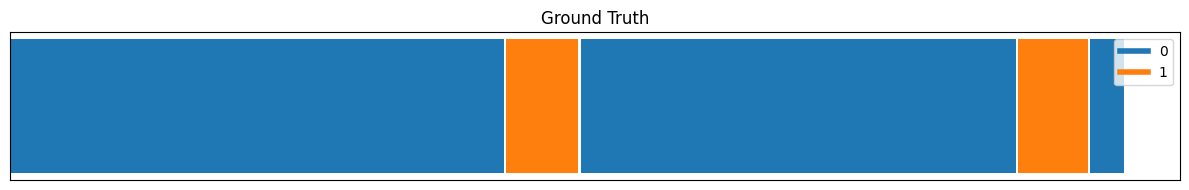

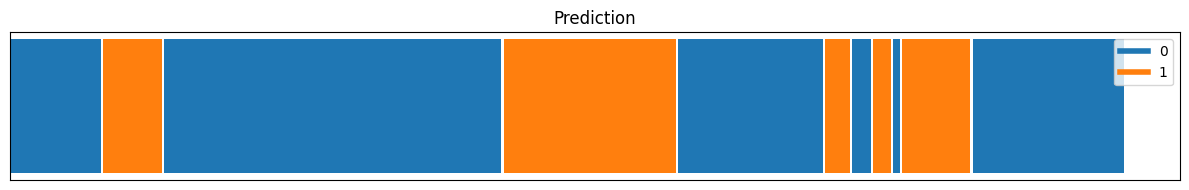

--- --- --- --- --- --- ---
[index]: 28
[outputs.shape]: torch.Size([173])
[labels.shape]: (173,)
[preds.shape]: (173,)


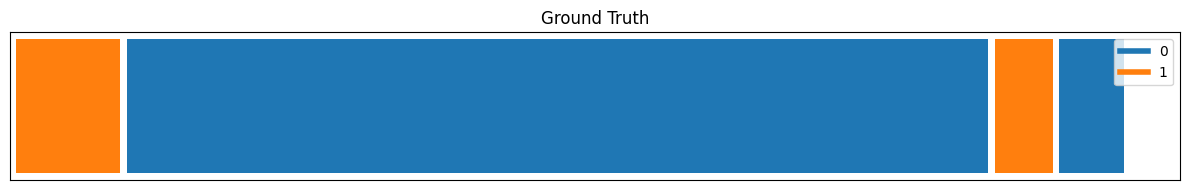

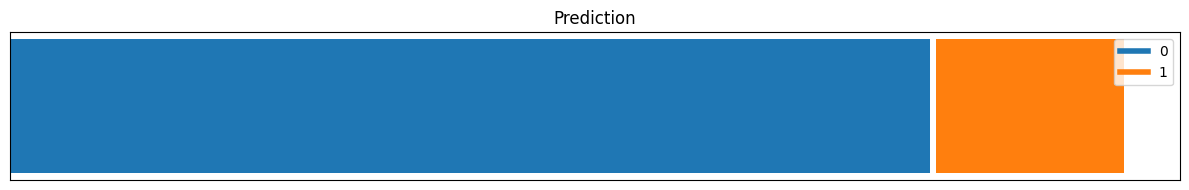

--- --- --- --- --- --- ---
[index]: 1074
[outputs.shape]: torch.Size([90])
[labels.shape]: (90,)
[preds.shape]: (90,)


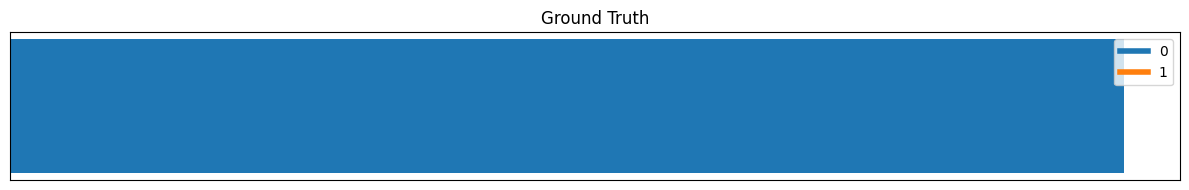

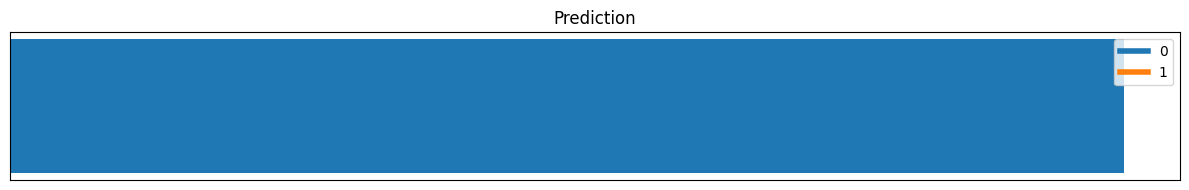

--- --- --- --- --- --- ---
[index]: 222
[outputs.shape]: torch.Size([599])
[labels.shape]: (599,)
[preds.shape]: (599,)


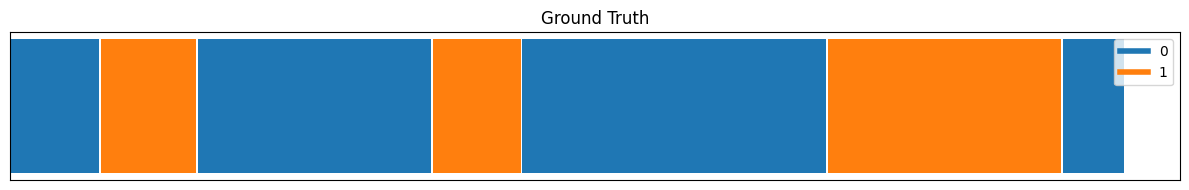

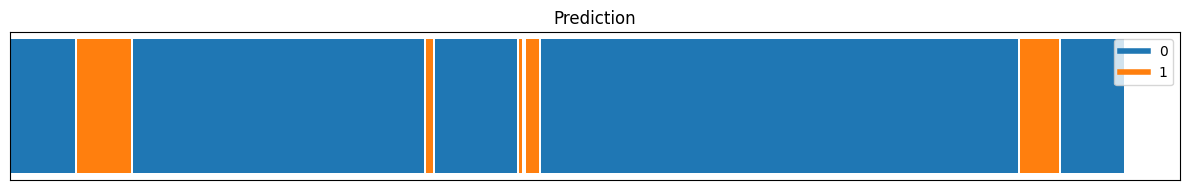

--- --- --- --- --- --- ---
[index]: 1460
[outputs.shape]: torch.Size([80])
[labels.shape]: (80,)
[preds.shape]: (80,)


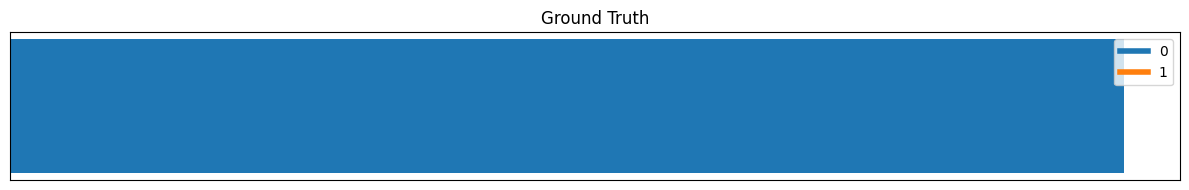

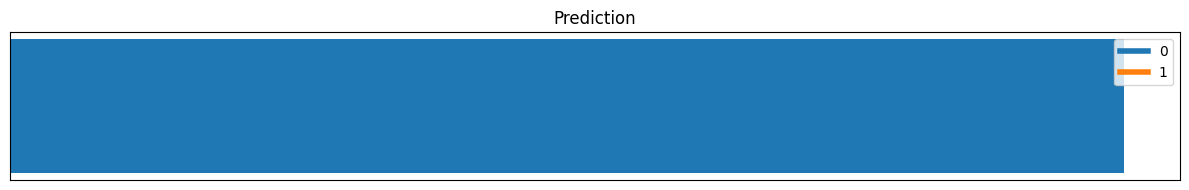

--- --- --- --- --- --- ---
[index]: 1291
[outputs.shape]: torch.Size([433])
[labels.shape]: (433,)
[preds.shape]: (433,)


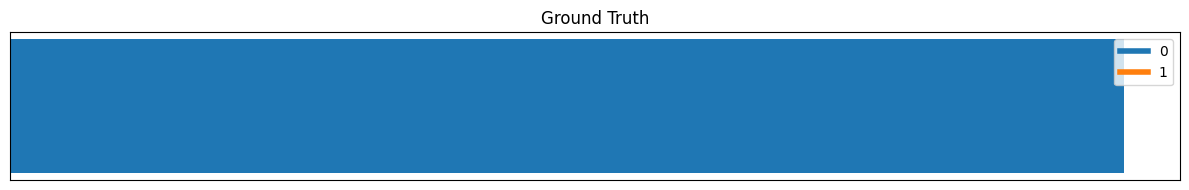

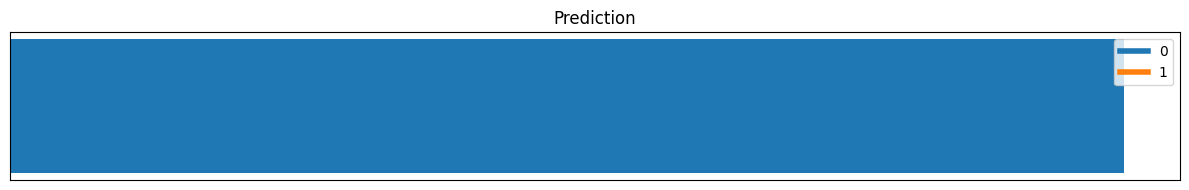

--- --- --- --- --- --- ---
[index]: 701
[outputs.shape]: torch.Size([2352])
[labels.shape]: (2352,)
[preds.shape]: (2352,)


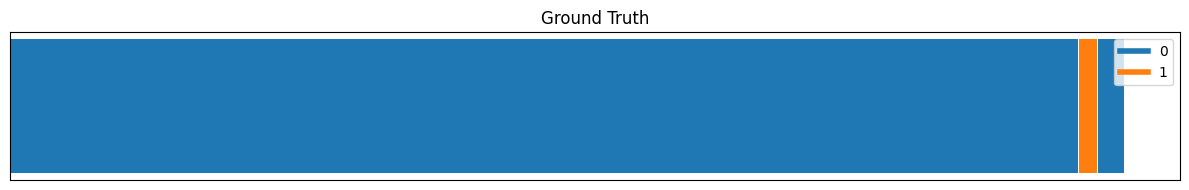

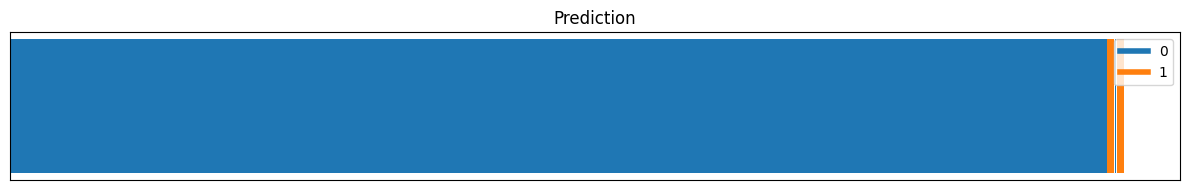

--- --- --- --- --- --- ---
[index]: 1140
[outputs.shape]: torch.Size([40])
[labels.shape]: (40,)
[preds.shape]: (40,)


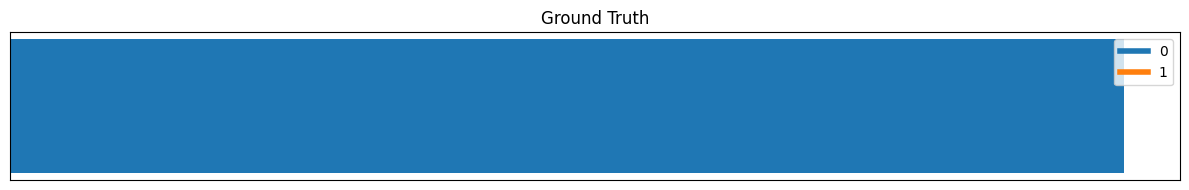

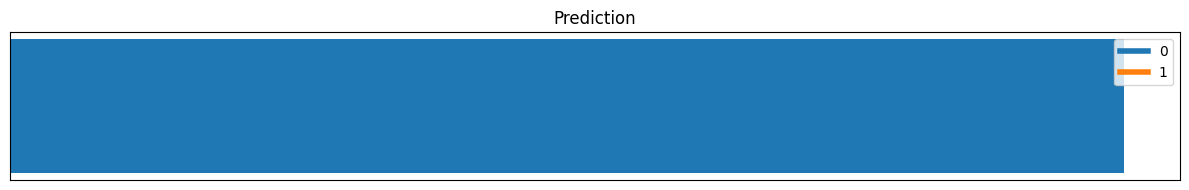

--- --- --- --- --- --- ---


In [17]:
import numpy as np

random_indices = np.random.choice(len(dataset), size=16, replace=False)

for index in random_indices:
    print("[index]:", index)

    sample = dataset[index]

    sample["transformed_motion"] = sample["transformed_motion"].to(device)
    sample["motion"] = sample["motion"].to(device)
    sample["transition_mask"] = sample["transition_mask"].to(device)

    y = sample["transition_mask"]

    outputs, exception = model.segment_sequence(
        sample,
        window_size=window_size,
        window_step=1,
        mean=mean,
        std=std
    )

    if exception is not None:
        logger.warning(f"[skipped-sequence]: {index} due to {exception}")
        continue

    print("[outputs.shape]:", outputs.shape)

    preds = outputs.cpu().numpy()
    labels = y.cpu().numpy()

    print("[labels.shape]:", labels.shape)
    print("[preds.shape]:", preds.shape)

    import matplotlib.pyplot as plt
    from tas_helpers.visualization import SegmentationVisualizer
    from tas_helpers.utils import (
        frame_level_annotations_to_segment_level_annotations,
    )

    visualizer = SegmentationVisualizer(labels_values=[0, 1])

    segmentation_1 = frame_level_annotations_to_segment_level_annotations(labels, fps=20)
    segmentation_2 = frame_level_annotations_to_segment_level_annotations(preds, fps=20)

    visualizer.plot_segmentation(labels, header="Ground Truth", fps=20, show_ticks=False)
    plt.show()

    visualizer.plot_segmentation(preds, header="Prediction", fps=20, show_ticks=False)
    plt.show()

    print("--- --- --- --- --- --- ---")

In [18]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

all_metrics = []
model_data = defaultdict(lambda: defaultdict(dict))

for output_path in output_paths:
    metrics = load_segmentation_metrics(output_path)
    if metrics is not None:
        model_name, window_size = parse_model_info(output_path)
        
        all_metrics.append({
            'model': model_name,
            'window_size': window_size,
            'framewise_accuracy': metrics['framewise_accuracy'],
            'edit_score': metrics['edit_score'],
            'balanced_accuracy': metrics['balanced_accuracy'],
            'matthews_corrcoef': metrics['matthews_corrcoef'],
            'false_positive_score': metrics['false_positive_score'],
            'f1@0.10': metrics['f1_scores']['f1@0.10'],
            'f1@0.20': metrics['f1_scores']['f1@0.20'],
            'f1@0.30': metrics['f1_scores']['f1@0.30'],
            'f1@0.40': metrics['f1_scores']['f1@0.40'],
            'f1@0.50': metrics['f1_scores']['f1@0.50'],
            'f1@0.60': metrics['f1_scores']['f1@0.60'],
            'f1@0.70': metrics['f1_scores']['f1@0.70'],
            'f1@0.80': metrics['f1_scores']['f1@0.80'],
            'f1@0.90': metrics['f1_scores']['f1@0.90'],
            'f1@1.00': metrics['f1_scores']['f1@1.00'],
            'transition_count_accuracy': metrics['transition_count_accuracy'],
            'class_0_precision': metrics['per_class']['0.0']['precision'],
            'class_0_recall': metrics['per_class']['0.0']['recall'],
            'class_0_f1': metrics['per_class']['0.0']['f1'],
            'class_1_precision': metrics['per_class']['1.0']['precision'],
            'class_1_recall': metrics['per_class']['1.0']['recall'],
            'class_1_f1': metrics['per_class']['1.0']['f1'],
        })
        
        model_data[model_name][window_size] = metrics

df = pd.DataFrame(all_metrics)

print(f"Loaded metrics for {len(all_metrics)} configurations")
print(f"Models: {df['model'].unique()}")
print(f"Window sizes: {sorted(df['window_size'].unique())}")

plt.style.use('default')
sns.set_palette("husl")

f1_thresholds = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]
window_sizes = sorted(df['window_size'].unique())

Loaded metrics for 21 configurations
Models: ['ST-GCN' 'TMR (no pretraining)' 'TMR (with pretraining)']
Window sizes: [np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50)]


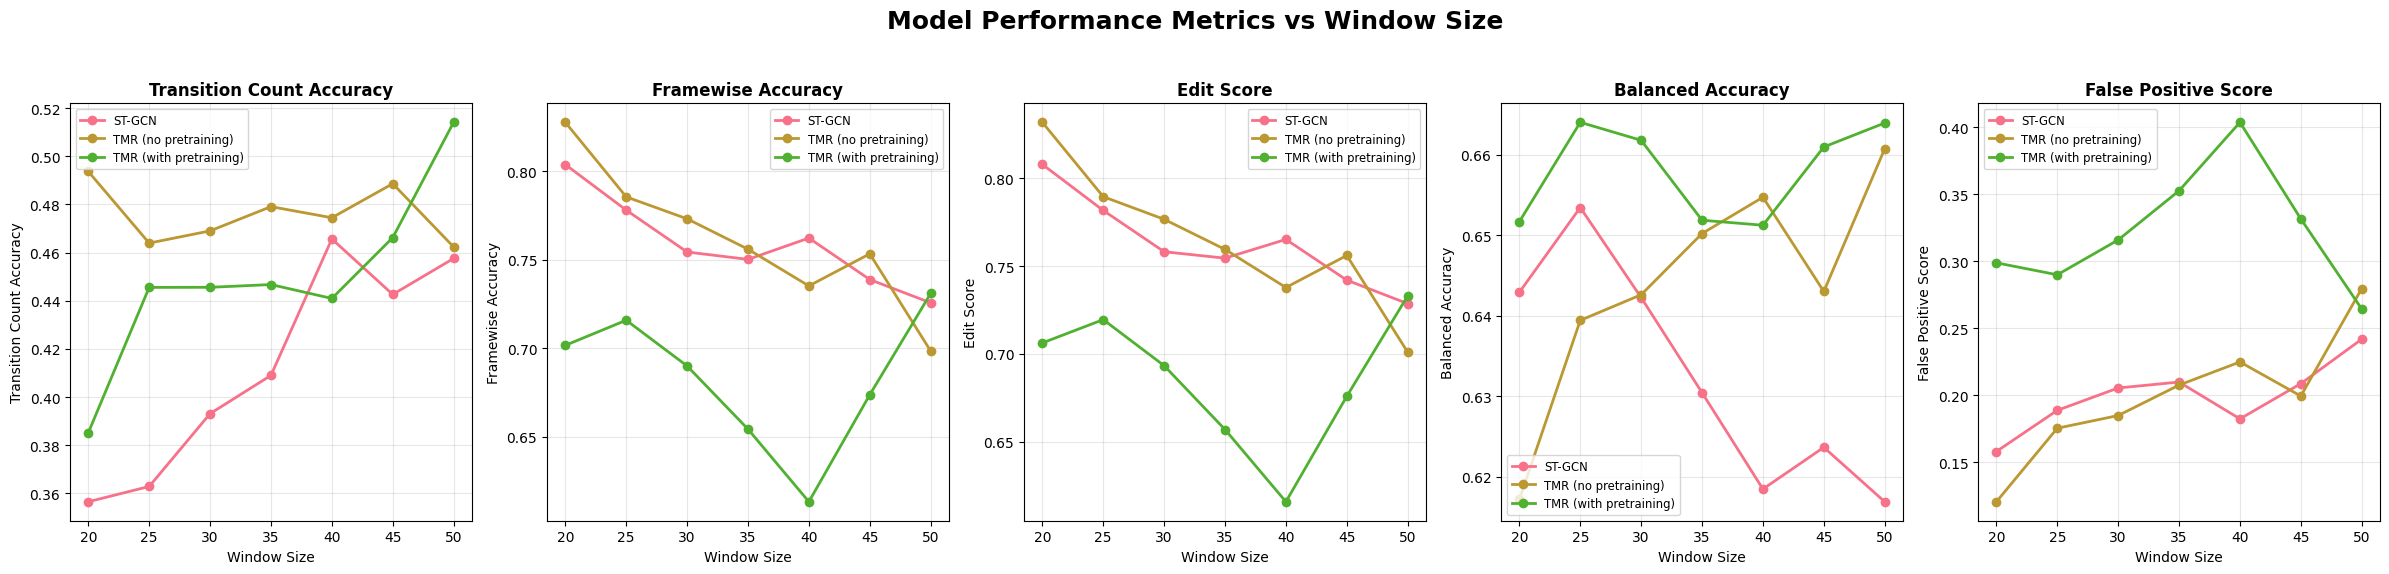

In [27]:
df['avg_f1'] = df[['f1@0.10', 'f1@0.50', 'f1@0.90']].mean(axis=1)

metrics = [
    ('transition_count_accuracy', 'Transition Count Accuracy'),
    ('framewise_accuracy', 'Framewise Accuracy'),
    ('edit_score', 'Edit Score'),
    ('balanced_accuracy', 'Balanced Accuracy'),
    ('false_positive_score', 'False Positive Score'),
]

fig, axes = plt.subplots(1, 5, figsize=(24, 6), sharex=True)
fig.suptitle('Model Performance Metrics vs Window Size', fontsize=18, fontweight='bold')

for ax, (metric_key, metric_label) in zip(axes, metrics):
    for model in df['model'].unique():
        model_df = df[df['model'] == model].sort_values('window_size')
        ax.plot(model_df['window_size'], model_df[metric_key], marker='o', linewidth=2, label=model)
    
    ax.set_title(metric_label, fontweight='bold')
    ax.set_xlabel('Window Size')
    ax.set_ylabel(metric_label)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

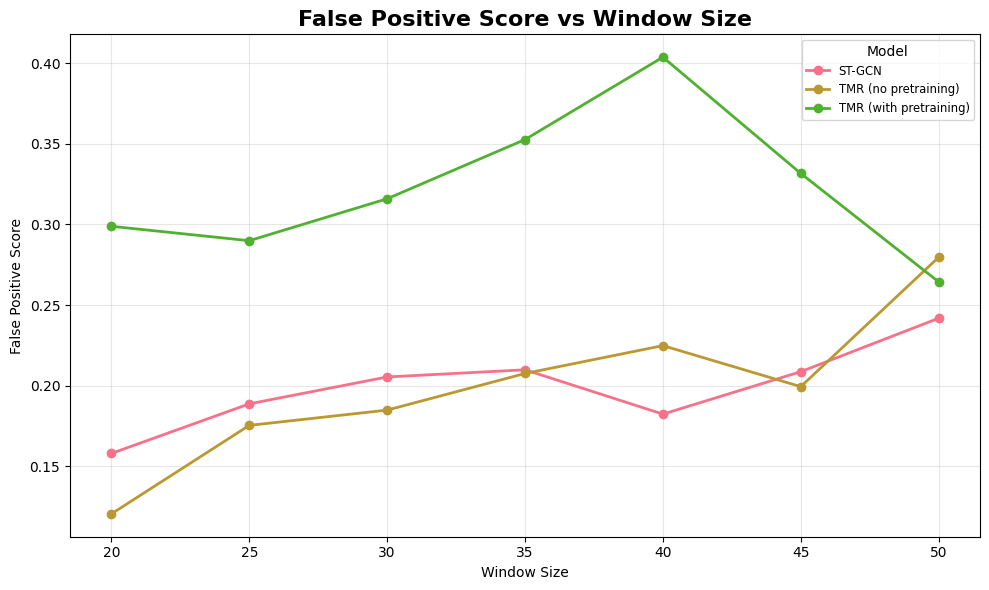

In [20]:
plt.figure(figsize=(10, 6))
plt.title('False Positive Score vs Window Size', fontsize=16, fontweight='bold')

for model in df['model'].unique():
    model_df = df[df['model'] == model].sort_values('window_size')
    plt.plot(model_df['window_size'], model_df['false_positive_score'], marker='o', linewidth=2, label=model)

plt.xlabel('Window Size')
plt.ylabel('False Positive Score')
plt.grid(True, alpha=0.3)
plt.legend(title='Model', fontsize='small')
plt.tight_layout()
plt.show()

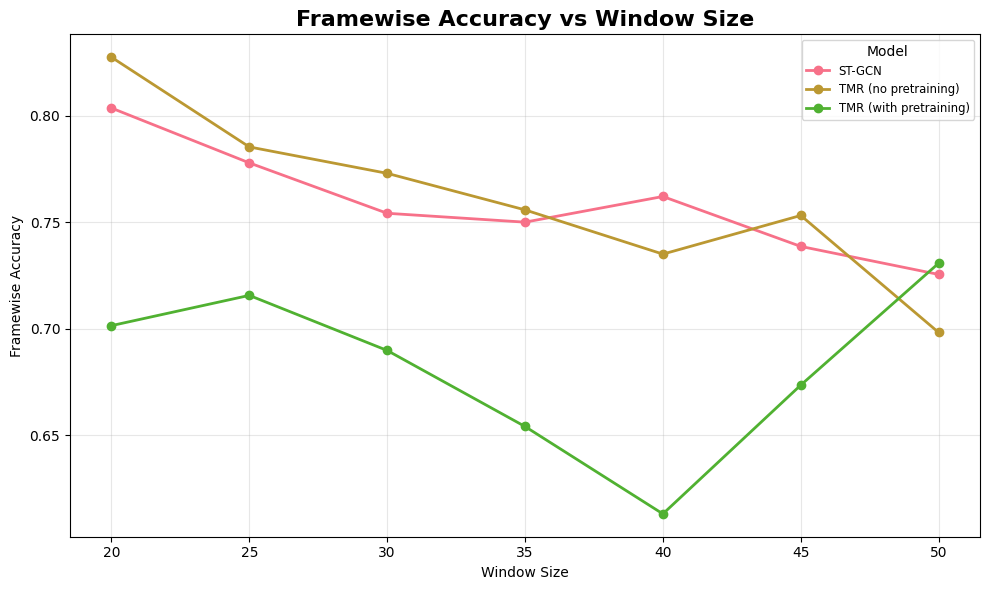

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Framewise Accuracy vs Window Size', fontsize=16, fontweight='bold')

for model in df['model'].unique():
    model_df = df[df['model'] == model].sort_values('window_size')
    plt.plot(model_df['window_size'], model_df['framewise_accuracy'], marker='o', linewidth=2, label=model)

plt.xlabel('Window Size')
plt.ylabel('Framewise Accuracy')
plt.grid(True, alpha=0.3)
plt.legend(title='Model', fontsize='small')
plt.tight_layout()
plt.show()

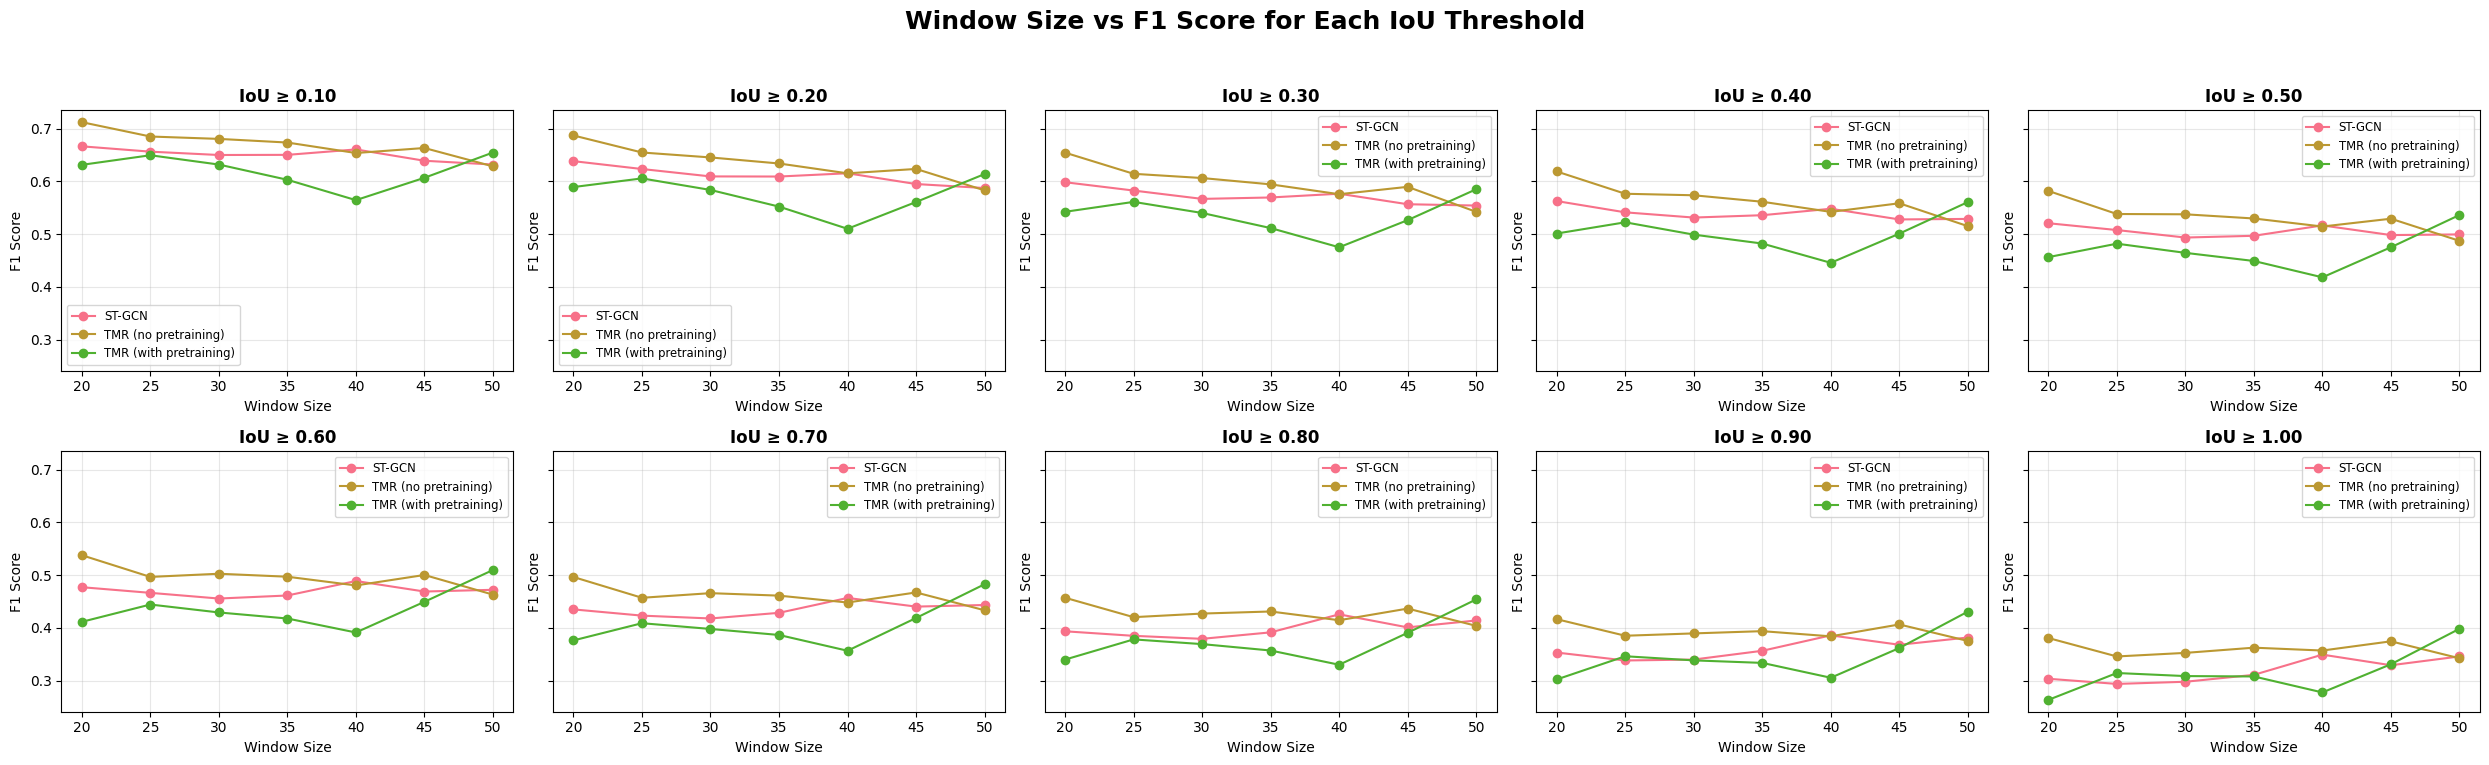

In [22]:
num_thresholds = len(f1_thresholds)
ncols = min(5, num_thresholds)
nrows = int(np.ceil(num_thresholds / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
fig.suptitle('Window Size vs F1 Score for Each IoU Threshold', fontsize=18, fontweight='bold')
axes = axes.flatten()

for idx, threshold in enumerate(f1_thresholds):
    ax = axes[idx]
    threshold_col = f'f1@{threshold:.2f}'
    
    for model in df['model'].unique():
        model_df = df[df['model'] == model].sort_values('window_size')
        ax.plot(model_df['window_size'], model_df[threshold_col], marker='o', label=model)
    
    ax.set_title(f'IoU ≥ {threshold:.2f}', fontweight='bold')
    ax.set_xlabel('Window Size')
    ax.set_ylabel('F1 Score')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize='small')

for i in range(len(f1_thresholds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

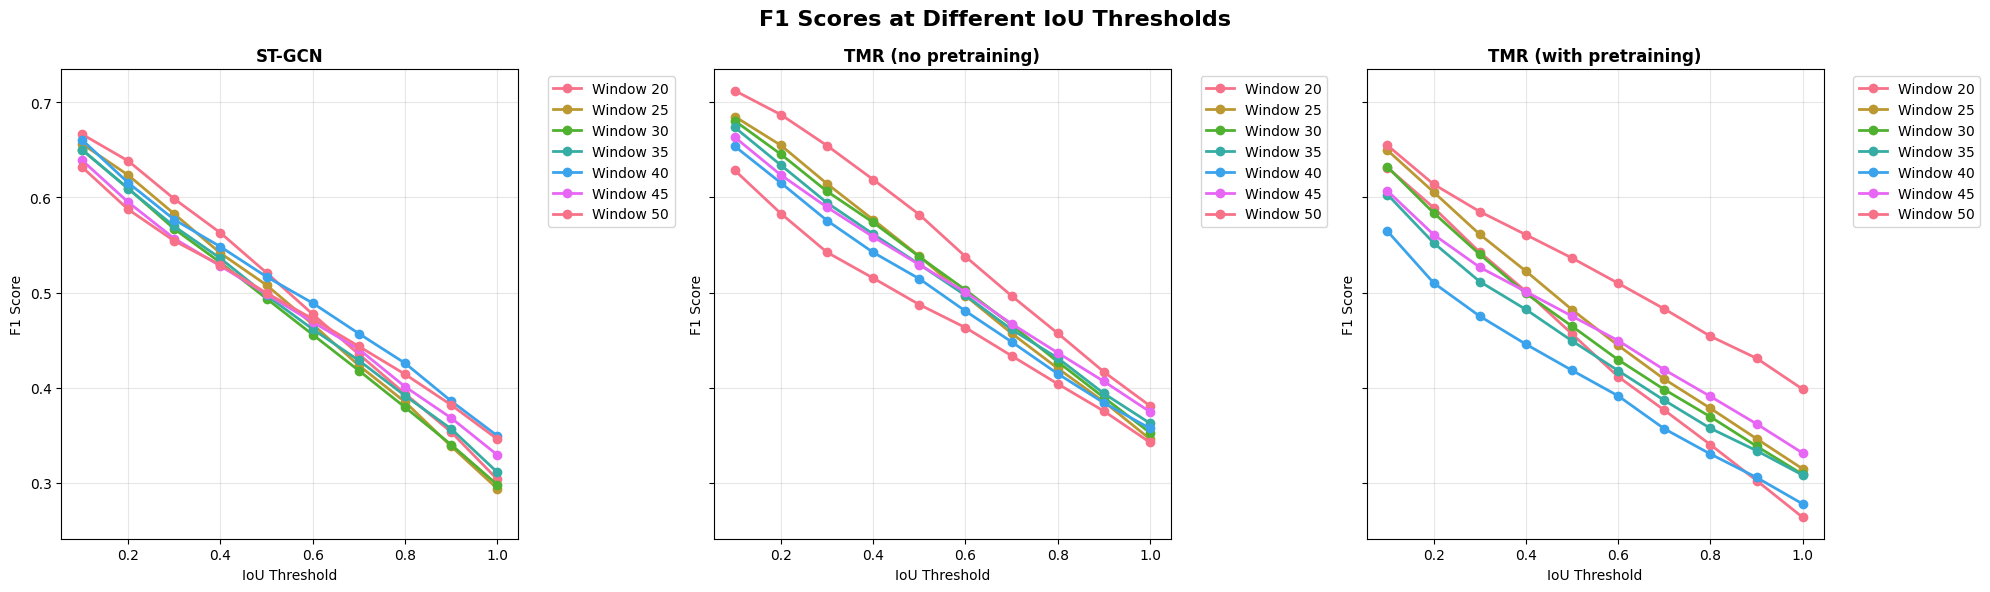

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('F1 Scores at Different IoU Thresholds', fontsize=16, fontweight='bold')

models = df['model'].unique()
for model_idx, model in enumerate(models):
    ax = axes[model_idx]
    
    for window_size in window_sizes:
        if model in model_data and window_size in model_data[model]:
            metrics = model_data[model][window_size]
            f1_values = [metrics['f1_scores'][f'f1@{thresh:.2f}'] for thresh in f1_thresholds]
            ax.plot(f1_thresholds, f1_values, marker='o', linewidth=2, 
                   label=f'Window {window_size}')
    
    ax.set_title(f'{model}', fontweight='bold')
    ax.set_xlabel('IoU Threshold')
    ax.set_ylabel('F1 Score')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

for model in models:
    print(f"\n{model}:")
    model_df = df[df['model'] == model]
    
    print(f"  Best Transition Count Accuracy: {model_df['transition_count_accuracy'].max():.4f} (Window {model_df.loc[model_df['transition_count_accuracy'].idxmax(), 'window_size']})")
    print(f"  Best False Positive Score: {model_df['false_positive_score'].max():.4f} (Window {model_df.loc[model_df['false_positive_score'].idxmax(), 'window_size']})")
    print(f"  Best Framewise Accuracy: {model_df['framewise_accuracy'].max():.4f} (Window {model_df.loc[model_df['framewise_accuracy'].idxmax(), 'window_size']})")
    print(f"  Best Edit Score: {model_df['edit_score'].max():.4f} (Window {model_df.loc[model_df['edit_score'].idxmax(), 'window_size']})")
    print(f"  Best F1@0.50: {model_df['f1@0.50'].max():.4f} (Window {model_df.loc[model_df['f1@0.50'].idxmax(), 'window_size']})")
    print(f"  Best F1@1.00: {model_df['f1@1.00'].max():.4f} (Window {model_df.loc[model_df['f1@1.00'].idxmax(), 'window_size']})")
    print(f"  Best Balanced Accuracy: {model_df['balanced_accuracy'].max():.4f} (Window {model_df.loc[model_df['balanced_accuracy'].idxmax(), 'window_size']})")


SUMMARY STATISTICS

ST-GCN:
  Best Transition Count Accuracy: 0.4657 (Window 40)
  Best False Positive Score: 0.2418 (Window 50)
  Best Framewise Accuracy: 0.8037 (Window 20)
  Best Edit Score: 0.8079 (Window 20)
  Best F1@0.50: 0.5207 (Window 20)
  Best F1@1.00: 0.3495 (Window 40)
  Best Balanced Accuracy: 0.6534 (Window 25)

TMR (no pretraining):
  Best Transition Count Accuracy: 0.4937 (Window 20)
  Best False Positive Score: 0.2796 (Window 50)
  Best Framewise Accuracy: 0.8276 (Window 20)
  Best Edit Score: 0.8319 (Window 20)
  Best F1@0.50: 0.5819 (Window 20)
  Best F1@1.00: 0.3810 (Window 20)
  Best Balanced Accuracy: 0.6607 (Window 50)

TMR (with pretraining):
  Best Transition Count Accuracy: 0.5141 (Window 50)
  Best False Positive Score: 0.4037 (Window 40)
  Best Framewise Accuracy: 0.7308 (Window 50)
  Best Edit Score: 0.7330 (Window 50)
  Best F1@0.50: 0.5362 (Window 50)
  Best F1@1.00: 0.3985 (Window 50)
  Best Balanced Accuracy: 0.6640 (Window 25)


In [25]:
print(f"\n{'='*80}")
print("BEST PERFORMING CONFIGURATIONS")
print("="*80)

key_metrics = ['transition_count_accuracy', 'framewise_accuracy', 'edit_score', 'f1@0.50', 'f1@0.90', 'f1@1.00', 'false_positive_score', 'balanced_accuracy']
for metric in key_metrics:
    best_idx = df[metric].idxmax()
    best_config = df.loc[best_idx]
    print(f"\nBest {metric.replace('_', ' ').title()}: {best_config[metric]:.4f}")
    print(f"  Model: {best_config['model']}")
    print(f"  Window Size: {best_config['window_size']}")


BEST PERFORMING CONFIGURATIONS

Best Transition Count Accuracy: 0.5141
  Model: TMR (with pretraining)
  Window Size: 50

Best Framewise Accuracy: 0.8276
  Model: TMR (no pretraining)
  Window Size: 20

Best Edit Score: 0.8319
  Model: TMR (no pretraining)
  Window Size: 20

Best F1@0.50: 0.5819
  Model: TMR (no pretraining)
  Window Size: 20

Best F1@0.90: 0.4310
  Model: TMR (with pretraining)
  Window Size: 50

Best F1@1.00: 0.3985
  Model: TMR (with pretraining)
  Window Size: 50

Best False Positive Score: 0.4037
  Model: TMR (with pretraining)
  Window Size: 40

Best Balanced Accuracy: 0.6640
  Model: TMR (with pretraining)
  Window Size: 25
